https://udlbook.github.io/udlbook/

https://github.com/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb

# **Блокнот 8.1: MNIST_1D_Performance**

Этот блокнот запускает простую нейронную сеть на наборе данных MNIST1D, как показано на рисунке 8.2a. Для генерации данных используется код из https://github.com/greydanus/mnist1d.

Пройдитесь по ячейкам ниже, запуская каждую ячейку по очереди. В разных местах вы увидите метку "TODO". Следуйте инструкциям в этих местах и сделайте прогнозы о том, что должно произойти, или напишите код для выполнения функций.

In [7]:
# Запустите это, если вы находитесь в Colab, чтобы создать локальную копию репозитория MNIST 1D
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 204 (delta 47), reused 60 (delta 41), pack-reused 128
Receiving objects: 100% (204/204), 8.42 MiB | 535.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [8]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Давайте сгенерируем обучающий и тестовый набор данных, используя код MNIST1D.  Набор данных сохраняется в виде файла .pkl, поэтому его не нужно будет каждый раз восстанавливать.

In [9]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# Входные и выходные данные для обучения и тестирования находятся в
# data['x'], data['y'], data['x_test'] и data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./sample_data/mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [10]:
D_i = 40    # Input dimensions # Входные размерности
D_k = 100   # Hidden dimensions # Скрытые размерности
D_o = 10    # Output dimensions # Выходные размерности
# TODO:
# Определите модель с двумя скрытыми слоями размерностью 100
# И ReLU активациями между ними
# Замените эту строку (смотрите справку на рисунке 7.8 книги):
model = torch.nn.Sequential(torch.nn.Linear(D_i, D_k), nn.ReLU(), nn.Linear(D_k,D_k), nn.ReLU(), nn.Linear(D_k,D_o))


def weights_init(layer_in):
  # TODO:
  # Инициализируйте параметры с помощью He initialization
  # Замените эту строку (смотрите справку на рисунке 7.8 книги)
  # Автор книги для эксперимента предлагает опробовать инициализацию весов, отличную от инициализации по умолчанию
  # Определите, есть ли от этого эффект, попробуйте с этой инициализацией и без
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

  print("Initializing layer")


In [11]:
# выберем в качестве функции потерь кросс-энтропию (уравнение 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# создадим оптимизатор (optimizer) SGD, инициализируем learning rate и momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# объект (scheduler), который снижает learning rate наполовину каждые 10 эпох
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# создадим 100 фиктивных точек данных и передадим их в класс загрузчика данных (data_loader)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# загрузим данные в класс, который создает пакеты (батчи)
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Инициализируем веса модели
model.apply(weights_init)

# цикл по набору данных n_epoch раз
n_epoch = 50
# store the loss and the % correct at each epoch
# сохраним потери и % правильности в каждой эпохе
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # цикл по батчам
  for i, batch in enumerate(data_loader):
    # извлечем входные данные и метки для этого батча
    x_batch, y_batch = batch
    # обнулим градиенты параметров
    optimizer.zero_grad()
    # прямой проход (forward pass) - вычислим выходные значения модели
    pred = model(x_batch)
    # вычислим функцию потерь
    loss = loss_function(pred, y_batch)
    # обратный проход (backward pass)
    loss.backward()
    # шаг стохастического градиентного спуска SGD (SGD update)
    optimizer.step()

  # Запустим на всем наборе данных, чтобы получить статистику
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # сообщим планировщику (scheduler) рассмотреть возможность обновления скорости обучения learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.554139, train error 60.75,  test loss 1.632115, test error 67.40
Epoch     1, train loss 1.285557, train error 46.40,  test loss 1.415181, test error 54.90
Epoch     2, train loss 1.142012, train error 42.12,  test loss 1.345066, test error 52.90
Epoch     3, train loss 0.990184, train error 36.38,  test loss 1.218075, test error 46.80
Epoch     4, train loss 0.863575, train error 30.57,  test loss 1.139680, test error 44.80
Epoch     5, train loss 0.765492, train error 26.78,  test loss 1.123979, test error 44.00
Epoch     6, train loss 0.689079, train error 24.12,  test loss 1.084890, test error 41.80
Epoch     7, train loss 0.646211, train error 22.68,  test loss 1.065588, test error 38.60
Epoch     8, train loss 0.546062, train error 18.20,  test loss 1.055427, test error 40.00
Epoch     9, train loss 0.508873, train error 16.65,  test loss 1.0

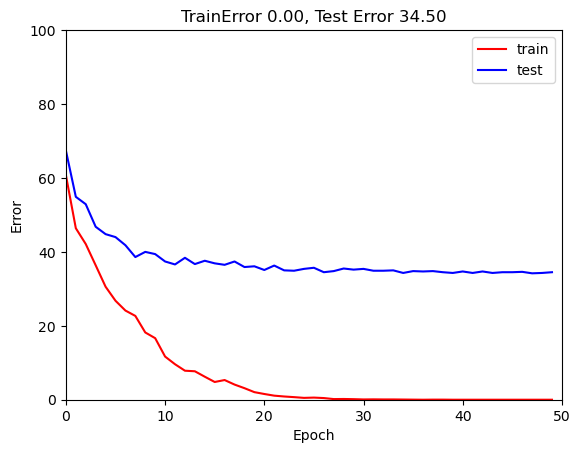

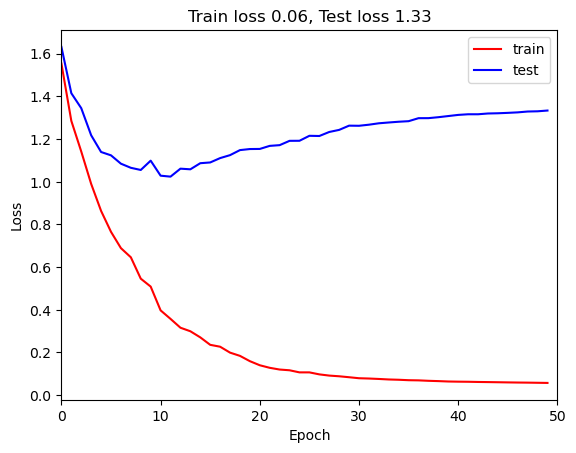

In [12]:
# Построим график результатов
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Построим график результатов
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Поиграйте с моделью - попробуйте изменить количество слоев (number of layers), скрытых блоков (hidden units), скорость обучения (learning rate), размер пакета (batch size),  momentum или что-нибудь еще, что вам нравится.  Посмотрите, сможете ли вы улучшить результаты тестирования.

Хорошая ли идея оптимизировать гиперпараметры таким образом?  Будет ли конечный результат хорошей оценкой истинной производительности на тестовых примерах?